In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [39]:
# Load your Excel file from Colab path
df = pd.read_excel("/content/Folds5x2_pp.xlsx")
df.columns = ['AT', 'V', 'AP', 'RH', 'PE']  # Rename columns
df.head()


,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


In [40]:
def normalize_series(series, buffer=0.05):
    min_val = series.min()
    max_val = series.max()
    range_val = max_val - min_val
    vmin = min_val - buffer * range_val
    vmax = max_val + buffer * range_val
    norm = -0.9 + 1.8 * (series - vmin) / (vmax - vmin)
    return norm, vmin, vmax

X = df[['AT', 'V', 'AP', 'RH']]
y = df['PE']
X_norm = X.copy()
params = {}

for col in X.columns:
    X_norm[col], vmin, vmax = normalize_series(X[col])
    params[col] = (vmin, vmax)

y_norm, y_vmin, y_vmax = normalize_series(y)


In [41]:
X_train, X_temp, y_train, y_temp = train_test_split(X_norm, y_norm, test_size=0.28, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=(10/28), random_state=42)

# Convert to NumPy arrays
X_train, X_val, X_test = X_train.values, X_val.values, X_test.values
y_train = y_train.values.reshape(-1, 1)
y_val = y_val.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)


In [42]:
def relu(x): return np.maximum(0, x)
def relu_derivative(x): return (x > 0).astype(float)

def tanh(x): return np.tanh(x)
def tanh_derivative(x): return 1.0 - np.tanh(x) ** 2

def sigmoid(x): return 1 / (1 + np.exp(-x))
def sigmoid_derivative(x): return sigmoid(x) * (1 - sigmoid(x))


In [43]:
def initialize_weights(layer_sizes):
    weights = []
    biases = []
    for i in range(len(layer_sizes) - 1):
        limit = np.sqrt(1 / layer_sizes[i])
        weights.append(np.random.uniform(-limit, limit, (layer_sizes[i], layer_sizes[i+1])))
        biases.append(np.zeros((1, layer_sizes[i+1])))
    return weights, biases


In [44]:
def forward(X, weights, biases, act='relu'):
    a = X
    activations = [X]
    pre_activations = []
    for i in range(len(weights)-1):
        z = np.dot(a, weights[i]) + biases[i]
        pre_activations.append(z)
        a = relu(z) if act == 'relu' else tanh(z) if act == 'tanh' else sigmoid(z)
        activations.append(a)
    z = np.dot(a, weights[-1]) + biases[-1]  # Output layer: linear
    pre_activations.append(z)
    activations.append(z)
    return activations, pre_activations

def backward(y_true, activations, pre_activations, weights, act='relu'):
    grads_w, grads_b = [], []
    m = y_true.shape[0]
    delta = (activations[-1] - y_true)
    for i in reversed(range(len(weights))):
        a_prev = activations[i]
        grads_w.insert(0, np.dot(a_prev.T, delta) / m)
        grads_b.insert(0, np.mean(delta, axis=0, keepdims=True))
        if i != 0:
            if act == 'relu':
                delta = np.dot(delta, weights[i].T) * relu_derivative(pre_activations[i-1])
            elif act == 'tanh':
                delta = np.dot(delta, weights[i].T) * tanh_derivative(pre_activations[i-1])
            elif act == 'sigmoid':
                delta = np.dot(delta, weights[i].T) * sigmoid_derivative(pre_activations[i-1])
    return grads_w, grads_b


In [45]:
def train_nn(X_train, y_train, X_val, y_val, act='relu', lr=0.001, batch_size=64, epochs=100):
    layer_sizes = [4, 64, 32, 1]
    weights, biases = initialize_weights(layer_sizes)
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        permutation = np.random.permutation(len(X_train))
        X_train = X_train[permutation]
        y_train = y_train[permutation]

        for i in range(0, len(X_train), batch_size):
            Xb = X_train[i:i+batch_size]
            yb = y_train[i:i+batch_size]
            activations, pre_activations = forward(Xb, weights, biases, act)
            dw, db = backward(yb, activations, pre_activations, weights, act)
            for j in range(len(weights)):
                weights[j] -= lr * dw[j]
                biases[j] -= lr * db[j]

        # Track losses
        train_pred = forward(X_train, weights, biases, act)[0][-1]
        val_pred = forward(X_val, weights, biases, act)[0][-1]
        train_losses.append(mean_squared_error(y_train, train_pred))
        val_losses.append(mean_squared_error(y_val, val_pred))

    return weights, biases, train_losses, val_losses


In [46]:
def inverse_transform(y_norm, vmin, vmax):
    return (y_norm + 0.9) * (vmax - vmin) / 1.8 + vmin

def evaluate_model(weights, biases, X_test, y_test, act='relu'):
    pred_norm = forward(X_test, weights, biases, act)[0][-1]
    y_pred = inverse_transform(pred_norm, y_vmin, y_vmax)
    y_true = inverse_transform(y_test, y_vmin, y_vmax)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 0.001))) * 100
    return y_true, y_pred, mse, rmse, mae, mape


In [47]:
weights, biases, tr_loss, val_loss = train_nn(X_train, y_train, X_val, y_val)
y_true, y_pred, mse, rmse, mae, mape = evaluate_model(weights, biases, X_test, y_test)

print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.4f}%")


MSE: 32.8291
RMSE: 5.7297
MAE: 4.4491
MAPE: 0.9785%


In [48]:
results = pd.DataFrame({
    'Actual PE': y_true.flatten(),
    'Predicted PE': y_pred.flatten(),
    'Error': (y_true - y_pred).flatten(),
    'Error %': (np.abs((y_true - y_pred) / (y_true + 0.001)) * 100).flatten()
})
results.to_csv("/content/CCPP_ANN_Predictions.csv", index=False)
print("Saved: CCPP_ANN_Predictions.csv")


Saved: CCPP_ANN_Predictions.csv


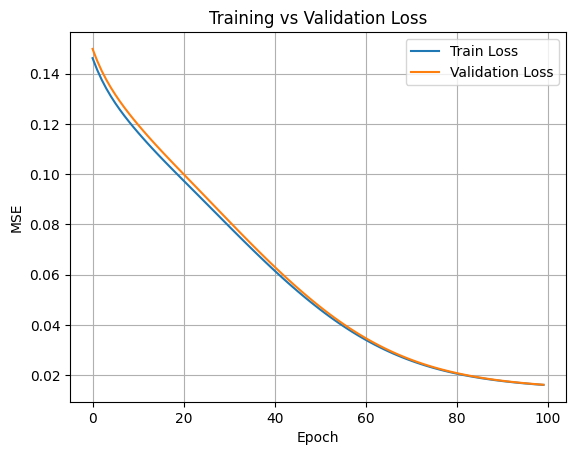

In [49]:
plt.plot(tr_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


Upgrade Model to Use Keras (TensorFlow)

In [50]:
!pip install -q tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


In [51]:
model = Sequential([
    Input(shape=(4,)),                # Explicit Input layer
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 64)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,433 (9.50 KB)

 Trainable params: 2,433 (9.50 KB)

 Non-trainable params: 0 (0.00 B)

In [52]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    verbose=1
)


Epoch 1/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0514 - mae: 0.1643 - val_loss: 0.0089 - val_mae: 0.0738
Epoch 2/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0088 - mae: 0.0732 - val_loss: 0.0083 - val_mae: 0.0717
Epoch 3/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0090 - mae: 0.0726 - val_loss: 0.0081 - val_mae: 0.0710
Epoch 4/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0080 - mae: 0.0698 - val_loss: 0.0083 - val_mae: 0.0723
Epoch 5/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0087 - mae: 0.0717 - val_loss: 0.0082 - val_mae: 0.0718
Epoch 6/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0084 - mae: 0.0708 - val_loss: 0.0079 - val_mae: 0.0702
Epoch 7/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0087 - mae: 0.0708 - val_loss: 0.0079 - val_mae: 0.0706
Epoch 8/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0080 - mae: 0.0699 - val_loss: 0.0078 - val_mae: 0.0694
Epoch 9/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 

In [53]:
test_predictions = model.predict(X_test)


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [54]:
def inverse_transform(y_norm, vmin, vmax):
    return (y_norm + 0.9) * (vmax - vmin) / 1.8 + vmin

y_pred = inverse_transform(test_predictions, y_vmin, y_vmax)
y_true = inverse_transform(y_test, y_vmin, y_vmax)


In [55]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / (y_true + 0.001))) * 100

print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.4f}%")


MSE: 16.5387
RMSE: 4.0668
MAE: 2.9258
MAPE: 0.6466%


In [56]:
results_df = pd.DataFrame({
    'Actual PE': y_true.flatten(),
    'Predicted PE': y_pred.flatten(),
    'Error': (y_true - y_pred).flatten(),
    'Error %': (np.abs((y_true - y_pred) / (y_true + 0.001)) * 100).flatten()
})
results_df.to_csv('/content/CCPP_Keras_ANN_Predictions.csv', index=False)


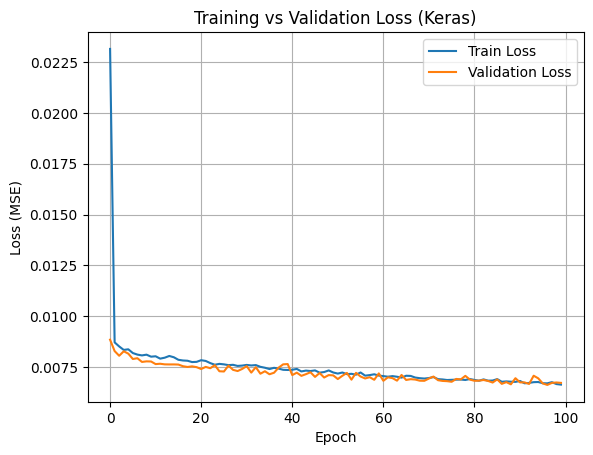

In [57]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training vs Validation Loss (Keras)')
plt.legend()
plt.grid(True)
plt.show()


Compare Before vs After Upgrade

In [58]:
import pandas as pd

# Load predictions from both models
before_df = pd.read_csv('/content/CCPP_ANN_Predictions.csv')       # NumPy model
after_df  = pd.read_csv('/content/CCPP_Keras_ANN_Predictions.csv') # Keras model


In [59]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def get_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 0.001))) * 100
    return round(mse, 4), round(rmse, 4), round(mae, 4), round(mape, 4)


In [60]:
mse_b, rmse_b, mae_b, mape_b = get_metrics(before_df['Actual PE'], before_df['Predicted PE'])
mse_a, rmse_a, mae_a, mape_a = get_metrics(after_df['Actual PE'], after_df['Predicted PE'])


In [61]:
comparison = pd.DataFrame({
    'Metric': ['MSE', 'RMSE', 'MAE', 'MAPE (%)'],
    'Before Upgrade (NumPy)': [mse_b, rmse_b, mae_b, mape_b],
    'After Upgrade (Keras)': [mse_a, rmse_a, mae_a, mape_a]
})
print(comparison)


     Metric  Before Upgrade (NumPy)  After Upgrade (Keras)
0       MSE                 32.8291                16.5387
1      RMSE                  5.7297                 4.0668
2       MAE                  4.4491                 2.9258
3  MAPE (%)                  0.9785                 0.6466


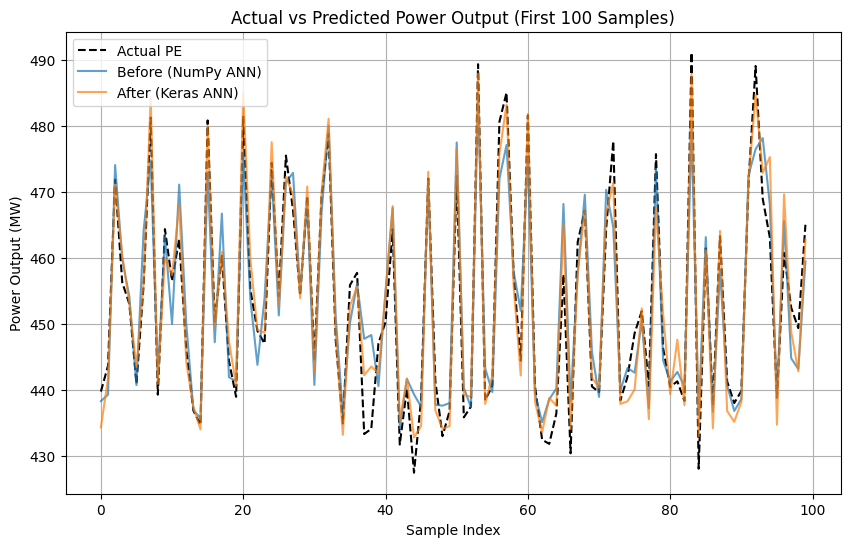

In [62]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(before_df['Actual PE'].values[:100], label='Actual PE', linestyle='--', color='black')
plt.plot(before_df['Predicted PE'].values[:100], label='Before (NumPy ANN)', alpha=0.7)
plt.plot(after_df['Predicted PE'].values[:100], label='After (Keras ANN)', alpha=0.7)
plt.title("Actual vs Predicted Power Output (First 100 Samples)")
plt.xlabel("Sample Index")
plt.ylabel("Power Output (MW)")
plt.legend()
plt.grid(True)
plt.show()


Compare Keras ANN with Other Models

In [63]:
!pip install -q xgboost
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor


In [64]:
# Linear Regression
lr_model = LinearRegression().fit(X_train, y_train)

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_train, y_train.ravel())

# XGBoost
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42).fit(X_train, y_train.ravel())


In [65]:
# Predictions (normalized)
lr_pred_norm = lr_model.predict(X_test)
rf_pred_norm = rf_model.predict(X_test)
xgb_pred_norm = xgb_model.predict(X_test)

# Inverse transform
def inverse_transform(y_norm, vmin, vmax):
    return (y_norm + 0.9) * (vmax - vmin) / 1.8 + vmin

# Convert to original scale
y_lr = inverse_transform(lr_pred_norm, y_vmin, y_vmax)
y_rf = inverse_transform(rf_pred_norm, y_vmin, y_vmax)
y_xgb = inverse_transform(xgb_pred_norm, y_vmin, y_vmax)
y_true = inverse_transform(y_test, y_vmin, y_vmax)


In [66]:
def get_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 0.001))) * 100
    return round(mse, 4), round(rmse, 4), round(mae, 4), round(mape, 4)

metrics_lr = get_metrics(y_true, y_lr)
metrics_rf = get_metrics(y_true, y_rf)
metrics_xgb = get_metrics(y_true, y_xgb)


In [67]:
comparison_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost', 'Keras ANN'],
    'MSE': [*metrics_lr[:1], *metrics_rf[:1], *metrics_xgb[:1], mse],
    'RMSE': [*metrics_lr[1:2], *metrics_rf[1:2], *metrics_xgb[1:2], rmse],
    'MAE': [*metrics_lr[2:3], *metrics_rf[2:3], *metrics_xgb[2:3], mae],
    'MAPE': [*metrics_lr[3:], *metrics_rf[3:], *metrics_xgb[3:], mape]
})
print(comparison_df)


               Model        MSE      RMSE       MAE      MAPE
0  Linear Regression  20.867100  4.568100  3.563200  0.786900
1      Random Forest  12.262800  3.501800  2.358700  4.215700
2            XGBoost  12.694200  3.562900  2.454400  4.212300
3          Keras ANN  16.538734  4.066784  2.925798  0.646608


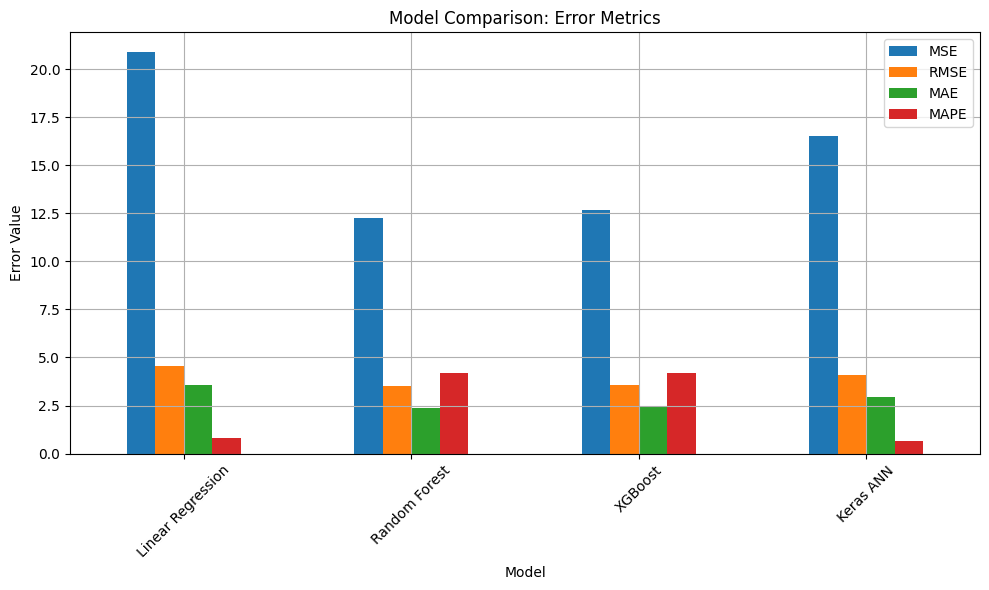

In [68]:
comparison_df.set_index("Model")[['MSE', 'RMSE', 'MAE', 'MAPE']].plot(kind='bar', figsize=(10, 6))
plt.title("Model Comparison: Error Metrics")
plt.ylabel("Error Value")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [71]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Function to calculate metrics
def get_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 0.001))) * 100
    return round(mse, 4), round(rmse, 4), round(mae, 4), round(mape, 4)

# Use your inverse-transformed predictions from each model
metrics_lr = get_metrics(y_true, y_lr)
metrics_rf = get_metrics(y_true, y_rf)
metrics_xgb = get_metrics(y_true, y_xgb)
metrics_keras = get_metrics(y_true, y_pred)  # from Keras ANN

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost', 'Keras ANN'],
    'MSE': [metrics_lr[0], metrics_rf[0], metrics_xgb[0], metrics_keras[0]],
    'RMSE': [metrics_lr[1], metrics_rf[1], metrics_xgb[1], metrics_keras[1]],
    'MAE': [metrics_lr[2], metrics_rf[2], metrics_xgb[2], metrics_keras[2]],
    'MAPE': [metrics_lr[3], metrics_rf[3], metrics_xgb[3], metrics_keras[3]]
})

# Save to CSV for Power BI
comparison_df.to_csv('/content/model_comparison_metrics.csv', index=False)
print(" Exported: model_comparison_metrics.csv")
comparison_df


 Exported: model_comparison_metrics.csv


,Model,MSE,RMSE,MAE,MAPE
0,Linear Regression,20.8671,4.5681,3.5632,0.7869
1,Random Forest,12.2628,3.5018,2.3587,4.2157
2,XGBoost,12.6942,3.5629,2.4544,4.2123
3,Keras ANN,16.5387,4.0668,2.9258,0.6466
